In [ ]:
################################################################################################
# OBJECTIVE:  #
# AUTHOR: Florence Garcia-Launay (florence.garcia-launay@inrae.fr) #
# LICENCE: CC0 1.0 Universal (CC0 1.0), Public Domain Dedication #
# LAST UPDATE: 2024-07-01 #
# VERSIONS : Python 3.11
################################################################################################


In [236]:
#A excécuter si Classes.py est modifié
import sys
del sys.modules['Classes_Step2']
del sys.modules['Functions_Step2']

In [237]:
from Classes_Step2 import *
from Functions_Step2 import *
from csv import *
import plotly.express as px

In [238]:
# INRAPorc parameters
dict_INRAPorc = {} # dictionnary of INRAPorc parameters
dict_INRAPorc['AAm75'] = [0.3611 + 0.1044, 0.0239 + 0.0045] # mg/kgBW0.75/d - coeff. basal turnover and integument loss in SID prot SID Lys () - van Milgen et al. 2008
dict_INRAPorc['AAendo'] = [8.5167, 0.3133] # g/kg DMI - coeff. basal endogenous losses for SID prot SID Lys - van Milgen et al. 2008
dict_INRAPorc['kAA'] = [0.85, 0.72] # maximum efficiency for SID prot and SID Lys - van Milgen et al. 2008
dict_INRAPorc['AAbody'] = [1, 0.0696] # g/g - Composition of body protein in prot and Lys
dict_INRAPorc['VarUrinELoss'] = 31.1
dict_INRAPorc['kProtJaap'] = 0.52
dict_INRAPorc['NEPD'] = 0.484 # kJ NE / kJ prot deposited - cost depositing 1 kJ prot
dict_INRAPorc['Pallom'] = 8.7845
dict_INRAPorc['Ballom'] = 0.94406
dict_INRAPorc['Lallom'] = 1.2566
dict_INRAPorc['FHPint'] = 436.47
dict_INRAPorc['FHPpente'] = 0.1298 / 0.74
dict_INRAPorc['Standing'] = 4
dict_INRAPorc['NEact60h'] = 150 / 2.9
dict_INRAPorc['kBR'] = 0.616 * 1.15
dict_INRAPorc['GEProtJaap'] = 23.8
dict_INRAPorc['PVmr1'] = 19.999
dict_INRAPorc['mrPV1'] = 8.4 * dict_INRAPorc['GEProtJaap']
dict_INRAPorc['mrPV2'] = 0
dict_INRAPorc['ValEnergy'] = [[22.64, 23.31, 20.34, 0, 0, 12.08], 
                             [38.76, 39.00, 39.00, 1, 35.01 / 39.00, 35.01],
                             [17.54, 17.45, 17.45, 1, 14.32 / 17.45, 14.32],
                             [16.71, 16.62, 16.62, 1, 11.94 / 16.62, 11.94],
                             [18.58, 16.61, 15.51, 15.51 / 16.61, 8.64 / 15.51, 8.64],
                             [18.58, 16.61, 15.51, 15.51 / 16.61, 8.64 / 15.51, 8.64]]

In [239]:
# General inputs
param = read_param('General_input_file_Step2_multiphase.csv')
n = param['Number_Phase']
seq_reul = []
if n > 1:
    for i in range(n - 1):
        seq_reulphase = [param['Mode'][i], param['Point_diet_change'][i + 1], param['Feed1'][i], param['Feed2'][i], param['Percentage_feed1'][i]]
        seq_reul += [seq_reulphase]

    seq_reulfin = [-1, 0.0, param['Feed1'][n - 1], param['Feed2'][n - 1], param['Percentage_feed1'][n-1]]
    seq_reul += [seq_reulfin]
# one phase
else:
    seq_reul = [[-1, 0.0, param['Feed1'], param['Feed2'], param['Percentage_feed1']]]

if param['Variability'] == 1: 
    dict_all_profiles = {}
    dict_profiles_females = lect_profile(param['file_profile_females']) # We read a file containing female profiles
    dict_profiles_males = lect_profile(param['file_profile_males'])  # We read a file containing male profiles
    list_profiles_males = list(dict_profiles_males.keys())
    half = round(param['nb_pigs']/2)
    for key in list_profiles_males[0:half]:
        dict_all_profiles[key] = dict_profiles_males[key]
    list_profiles_females = list(dict_profiles_females.keys())
    for key in list_profiles_females[0:(param['nb_pigs']-half)]:
        dict_all_profiles[key] = dict_profiles_females[key]
elif param['Variability'] == 0:
    dict_all_profiles = lect_profile(param['file_profile'])

dict_aliments = lect_feed(param['file_feeds'])


input_file = open(param["file_inputLCA"], "r", encoding='latin-1')
c = reader(input_file, delimiter=';')
next(c)  # Skip the first line (the headers)
input_calcLCA = {}
for row in c:
    clef = row[0]
    ch1 = row[2] + '(' + row[1] + ')'  # On stocke la valeur de la variable sous forme de chaine de caractère
    input_calcLCA[clef] = eval(ch1)
input_file.close()

CF = pd.read_csv('CF.csv', delimiter=';', decimal=".", header=0, index_col=0, encoding='latin1')
Background_data = pd.read_csv('Background_Data.csv', delimiter=';', decimal=".", header=12, index_col=0,
                                  encoding='latin1')


In [240]:
# initializing the objects

My_Batch = Batch(profile = dict_all_profiles, Variability = param['Variability'],
                 nb_pigs = param['nb_pigs'],
                 ruleseq = seq_reul, 
                 Ageimoy = param['Ageimoy'],
                 BWimoy = param['BWimoy'],
                 dict_INRAPorc = dict_INRAPorc,
                 ID='B0')

My_Feed_Storage = Feed_storage(dict_aliments)


In [241]:
# Preparing output files

f_perf = open("Performances %s .txt" % (param['scenario']), "w")
print(
    "Scenario" + '\t' + "Pig" + '\t' + "Profile" + '\t' + "delivery" + '\t' + "AgeInit_d" + '\t' + "SlaughterAge_d" + '\t' + "BWInit_kg" + '\t' + "SlaughterBW_kg" + '\t' + "ProtInit_kg" + '\t' + "FinalProt_kg" + '\t' +
    "LipInit_kg" + '\t' + "FinalLip_kg" + '\t' + "CumulFeedIntake_kg" + '\t' + "N_intake_kg" + '\t' + "excreted_N_kg" + '\t' + "excreted_TAN_kg" + '\t' + "ADG_kg_d" + '\t' + "FCR_kg_kg"
    + '\t' + "Feed1" + '\t' + "IntakeFeed1_kg" + '\t' + "Feed2" + '\t' + "IntakeFeed2_kg" 
    , file=f_perf)
f_perf.flush()

f_daily = open("Daily_output %s.txt" % (param['scenario']), "w")
print(
    "Scenario" + ' ' + "Pig" + ' ' + "Profile" + ' ' + "Day" + ' ' + "Age_d" + ' ' + "BW_kg" + ' ' + "" + ' ' + "Daily_Gain_kg" + ' ' + "BodyProt_kg" + ' ' + "BodyLip_kg" + ' ' + 
     "Feed_intake_kg_d" + ' ' + "FecalN_kg_d" + ' ' + "UrinN_kg_d" , file=f_daily)
f_daily.flush()



In [242]:
# Preparing output file for LCA results 

f_lca = open("Performances_LCA %s .txt" % (param['scenario']), "w")
print(
    "Scenario" + ' ' + "Pig" + ' ' + "Profile" + ' ' + "CC_feed_kgCO2eq_pig" + ' ' + "AC_feed_molH+eq_pig" + ' ' + "CC_kgCO2eq_kgBWG" + ' ' + "AC_molH+eq_kgBWG" , file=f_lca)
f_lca.flush()

In [243]:
# Simulation with lca
AGENDA = {(param['duration']): ['My_Batch.delivery(My_Feed_Storage, param, input_calcLCA, function_LCA_pig,  CF, Background_data, f_perf, f_lca, i)'], 
          (param['duration']-7): ['My_Batch.delivery(My_Feed_Storage, param, input_calcLCA, function_LCA_pig, CF, Background_data, f_perf, f_lca, i)'],
          (param['duration']-14): ['My_Batch.delivery(My_Feed_Storage, param, input_calcLCA, function_LCA_pig, CF, Background_data, f_perf, f_lca, i)'], 
          (param['duration']-21): ['My_Batch.delivery(My_Feed_Storage, param, input_calcLCA, function_LCA_pig, CF, Background_data, f_perf, f_lca, i)'],
          (param['duration']-28): ['My_Batch.delivery(My_Feed_Storage, param, input_calcLCA, function_LCA_pig, CF, Background_data, f_perf, f_lca, i)']}

for i in range(param['duration']+1):
    if len(My_Batch.IDpigs) > 0 :
        My_Batch.batch_growth(My_Feed_Storage, dict_INRAPorc, param, function_INRAPorc, f_daily, i)
        if i in AGENDA.keys():
            for evs in AGENDA[i]:
                exec(evs)

f_perf.close()
f_daily.close()
f_lca.close()
    

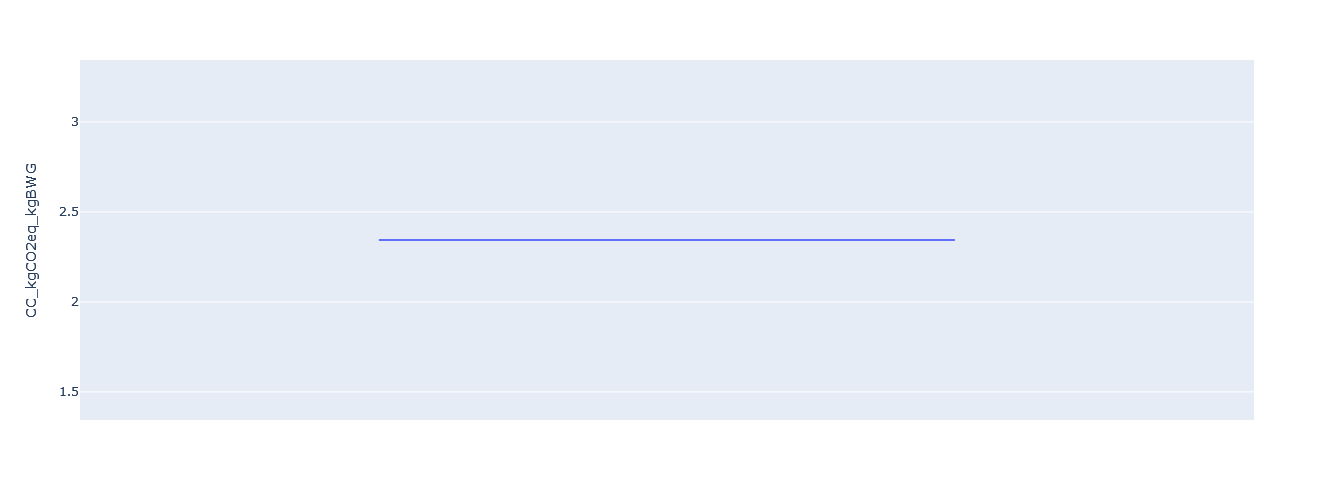

In [244]:
performances_LCA = {}
performances_LCA[param['scenario']] = pd.read_csv("Performances_LCA %s .txt" % (param['scenario']), sep=' ', header =0)
CC_kgCO2eq_kgBWG = px.box(performances_LCA[param['scenario']],y='CC_kgCO2eq_kgBWG', height = 500)
CC_kgCO2eq_kgBWG.show()

# performances_LCA_tot = pd.concat([performances_LCA['Step2_multiphase_Variability0'],performances_LCA['Step2_multiphase']], axis=0)
# CC_kgCO2eq_kgBWG = px.box(performances_tot,x='Scenario', y='CC_kgCO2eq_kgBWG', height = 500)
# CC_kgCO2eq_kgBWG.show()

In [245]:
performances_LCA[param['scenario']]

,Scenario,Pig,Profile,CC_feed_kgCO2eq_pig,AC_feed_molH+eq_pig,CC_kgCO2eq_kgBWG,AC_molH+eq_kgBWG
0,Step2_multiphase_Variability0,B0P0,1-F1,126.544,2.468,2.344,0.059
1,Step2_multiphase_Variability0,B0P1,1-F1,126.544,2.468,2.344,0.059
2,Step2_multiphase_Variability0,B0P10,1-F1,126.544,2.468,2.344,0.059
3,Step2_multiphase_Variability0,B0P11,1-F1,126.544,2.468,2.344,0.059
4,Step2_multiphase_Variability0,B0P12,1-F1,126.544,2.468,2.344,0.059
...,...,...,...,...,...,...,...
95,Step2_multiphase_Variability0,B0P95,1-F1,126.544,2.468,2.344,0.059
96,Step2_multiphase_Variability0,B0P96,1-F1,126.544,2.468,2.344,0.059
97,Step2_multiphase_Variability0,B0P97,1-F1,126.544,2.468,2.344,0.059
98,Step2_multiphase_Variability0,B0P98,1-F1,126.544,2.468,2.344,0.059
